### Data caveats and main results

Binary classification model comparison using synthetic data acquired here (https://www.kaggle.com/datasets/bhrt97/hr-analytics-classification). The dataset was incomplete, missing the ground truth values for the test set. Therefore, I divided the train set into chunks to create my own test set. Additionally, none of the features present in the dataset contained much information (i.e., were correlated with) the target feature: a binary feature about company promotions.

Instead of abandoning the project, I took it as a challenge to see how much I could improve classification scores with different techniques using the validation dataset. Scaling and under/oversampling were used to improve these scores due to the minority class status of the target feature. These approaches yielded limited results. With the non preprocessed features having equal or better results than the preprocessed ones. At the same time, the results serve as a good example of the well-known trade-off present in classification metrics (e.g., 'accuracy' and 'recall'), undersampling the training data resulted in a lower F1 score, with very high recall values (0.796) as a consequence of lowering accuracy. In this scenario, companies would face a choice between potentially overlooking 70% of future promotees, while having confidence in the suitability of the remaining 30%, or accurately identifying 93% of true promotees, even if it means that 3 out of 4 model predictions are incorrect. Incorporating additional features that contribute valuable information to the model could offer a viable and obvious solution to effectively address this classification challenge.

### Usefulness 

HR departments would benefit from advance knowledge about which candidates are more suitable for promotion. Predicting potential promotees could enable companies to prepare better for the necessary steps during role transitions. Understanding the features or characteristics of workers that align with successful promotions could incentivize companies to nurture and encourage these qualities within their staff.



### Dataset information 

Features included:

* employee_id: employee id
* department: name of the deparment the employee works at
* region: number of the region the employee works at, ranges from 1 to 34
* education: level of education the employee has
* gender: gender of teh employee
* recruitment_channel: which method was used to recruit the employee
* no_of_trainings: number of training the employee has had, ranging from 1 to 10
* age: age of the employee
* previous_year_rating: work rating the employee obtained one year before, ranges from 1 to 5
* length_of_service: number of years the employee has worked on the company
* KPIs_met >80%: indicates if the Key Performance Indicators were met above a 80% threshold 
* awards_won?: indicates if the employee has won an award while working on the company
* avg_training_score: average score of the training processes performed while in the company
* is_promoted: our target variable, indicates if the employee has been promoted or not


Hope you enjoy it! Any feedback is welcome at borjadaguerre@gmail.com.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import seaborn as sns
import random
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

warnings.filterwarnings("ignore")

In [2]:
# Test set does not contain target values, train set has been split into train a test

df = pd.read_csv(r'C:\Users\gebruiker\Documents\DataScience\DatasSets\train_LZdllcl.csv')
train = df[:int(len(df) * 0.75)]
test = df[int(len(df) * 0.75):]

len(train) + len(test) == len(df)

True

In [3]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
# Drop 'employer_id' becuase is irrelevant

test = test.drop(columns = ['employee_id'])
train = train.drop(columns = ['employee_id'])

In [5]:
# Check data types by features

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            41106 non-null  object 
 1   region                41106 non-null  object 
 2   education             39267 non-null  object 
 3   gender                41106 non-null  object 
 4   recruitment_channel   41106 non-null  object 
 5   no_of_trainings       41106 non-null  int64  
 6   age                   41106 non-null  int64  
 7   previous_year_rating  38002 non-null  float64
 8   length_of_service     41106 non-null  int64  
 9   KPIs_met >80%         41106 non-null  int64  
 10  awards_won?           41106 non-null  int64  
 11  avg_training_score    41106 non-null  int64  
 12  is_promoted           41106 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 4.1+ MB


In [6]:
# Check for missing values 

train.isna().sum()

department                 0
region                     0
education               1839
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3104
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

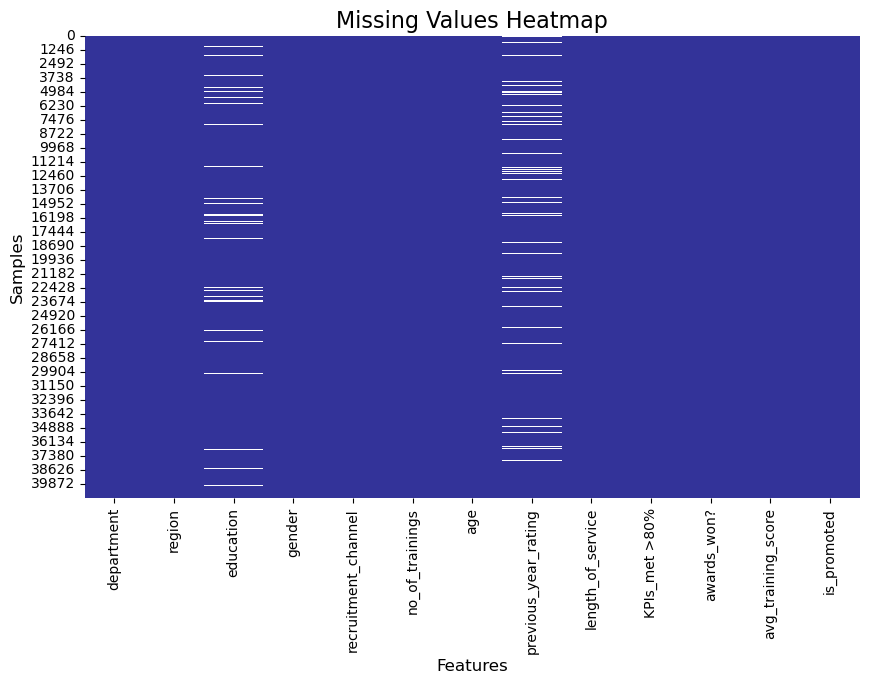

In [30]:
# Check if the missing values are regularly disrtibuted 

missing_values = train.isnull()
plt.figure(figsize=(10, 6)) 
sns.heatmap(missing_values, cmap='terrain', cbar=False) 
plt.xticks(rotation=90)
plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Samples', fontsize=12)
plt.show()


In [31]:
# Check if NaN values in 'previous_year_rating' are due to first year workers with 0 years in 'length of service'

train['length_of_service'].value_counts().head()

3    5271
4    5132
2    5013
5    4397
7    4187
Name: length_of_service, dtype: int64

In [32]:
# Replace the NaN vallues of the feature education with the 'Unknoww' value

train['education'].fillna('Unknown', inplace=True)
test['education'].fillna('Unknown', inplace=True)

In [33]:
# First split of categorical and numerical vairables 

categorical = train.select_dtypes(include=['object'])
numerical = train.select_dtypes(include=['int64','float64'])

In [34]:
# Perform one-hot encoding on the categorical columns

one_hot_encoded_train = pd.get_dummies(train[categorical.columns], prefix=categorical.columns)
one_hot_encoded_test = pd.get_dummies(test[categorical.columns], prefix=categorical.columns)


# Concatenate the one-hot encoded columns to the original DataFrame

train = pd.concat([train, one_hot_encoded_train], axis=1)
test = pd.concat([test, one_hot_encoded_test], axis=1)

In [12]:
# Matrix is too sparse to detect good correlation, search for the most important ones

correlation_matrix = train.corr()

correlations = {}
for row, row_val in correlation_matrix.iterrows():
    for col, col_val in row_val.iteritems():
        if col_val > 0.3 and col_val != 1 and col_val not in correlations.values():
            correlations[row + ' WITH ' + col] = col_val
correlations      

{'age WITH length_of_service': 0.6575041616422712,
 "age WITH education_Master's & above": 0.3637629859511988,
 'previous_year_rating WITH KPIs_met >80%': 0.3499005378484739,
 'avg_training_score WITH department_Analytics': 0.5207013373938391,
 'avg_training_score WITH department_Technology': 0.4789708414905947}

In [35]:
# Imputing the NaN values of 'previous_year_rating' with the training mean, interpolation with through a linear method  is also 
# available since 'previouos_year_rating' is lighly correlated with 'KPI_met > 80%'

train['previous_year_rating'].fillna(int(train['previous_year_rating'].mean()), inplace = True)
test['previous_year_rating'].fillna(int(train['previous_year_rating'].mean()),inplace = True)


In [14]:
# Linear data interpolation of 'previous_year_rating' using the highest correlated feature 'KPIs_met > 80%'

#train['inter_previous_year_rating'] = train['previous_year_rating'].interpolate(method='linear', x=train['KPIs_met >80%'])
#train  = train.drop('previous_year_rating', axis = 1)

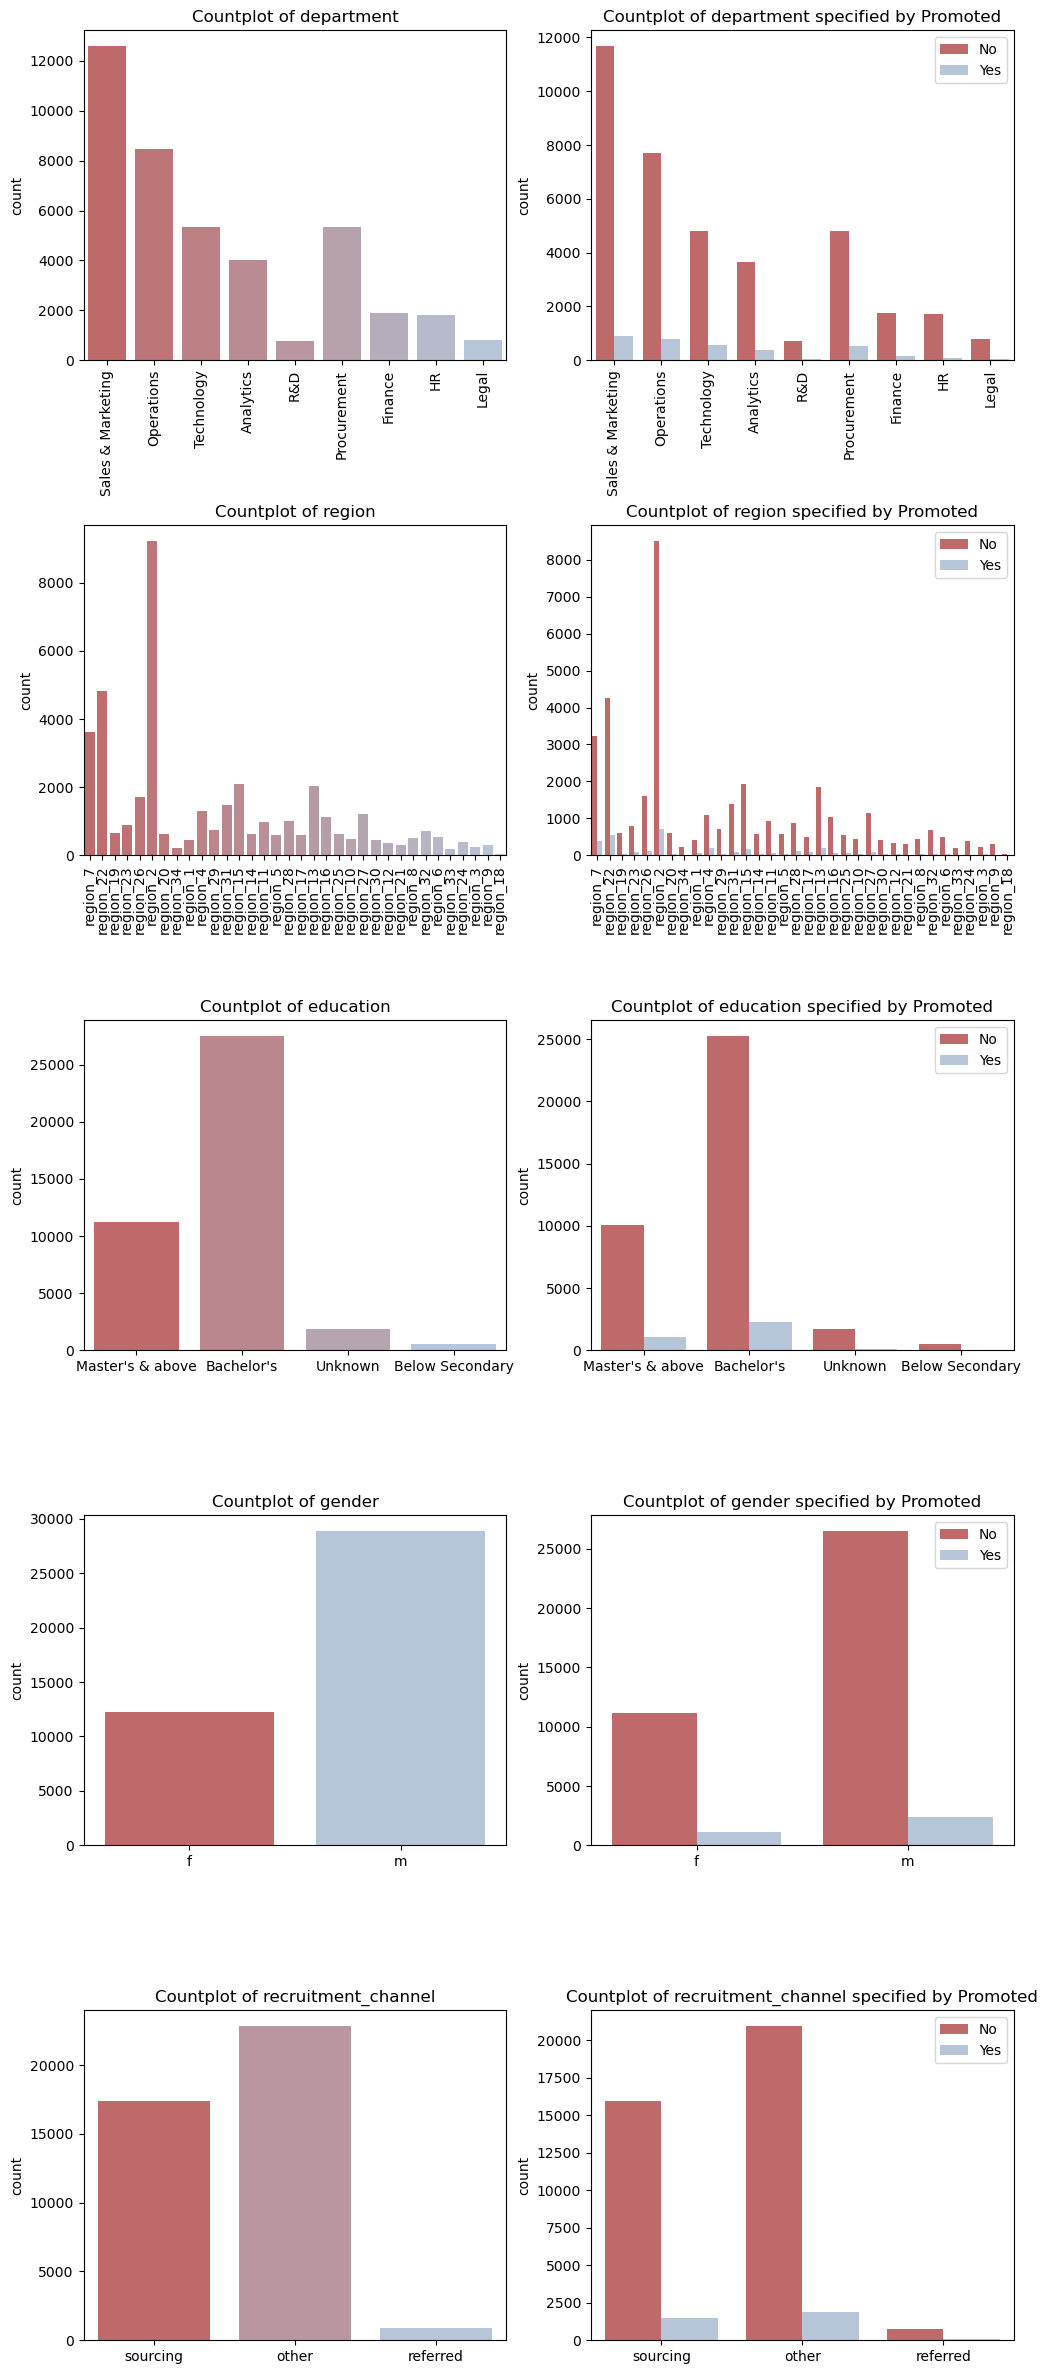

In [39]:
# Visual representation of the categorical variables attending to their frequency and their frequency specified by promotions

promotions = ['Yes' if i == 1 else 'No' for  i in train['is_promoted']]


fig, axes = plt.subplots(nrows=len(categorical.columns), ncols=2, figsize=(12, 6 * len(categorical.columns)))
fig.subplots_adjust(hspace=0.5)


for col, ax in zip(categorical, axes):
    sns.countplot(data=train, x=col, ax= ax[0], palette="blend:indianred,lightsteelblue")

    ax[0].set_title(f"Countplot of {col}")
    ax[0].set_xlabel("")
    
    x_labels = [tick.get_text() for tick in ax[0].get_xticklabels()]
    if '0' in x_labels and '1' in x_labels:
        ax[0].set_xticklabels(['No', 'Yes'])
        
    if len(np.unique(train[col])) > 5:
        ax[0].xaxis.set_tick_params(rotation = 90)

        
  

        # Plot countplot
    sns.countplot(data=train, x=col, hue=promotions, ax=ax[1], palette="blend:indianred,lightsteelblue")
    ax[1].set_title(f"Countplot of {col} specified by {'Promoted'}")
    ax[1].set_xlabel("")  
    
    if len(np.unique(train[col])) > 5:
        ax[1].xaxis.set_tick_params(rotation = 90)
    
    x_labels = [tick.get_text() for tick in ax[1].get_xticklabels()]
    if '0' in x_labels and '1' in x_labels:
        ax[1].set_xticklabels(['No', 'Yes'])

    

plt.show()

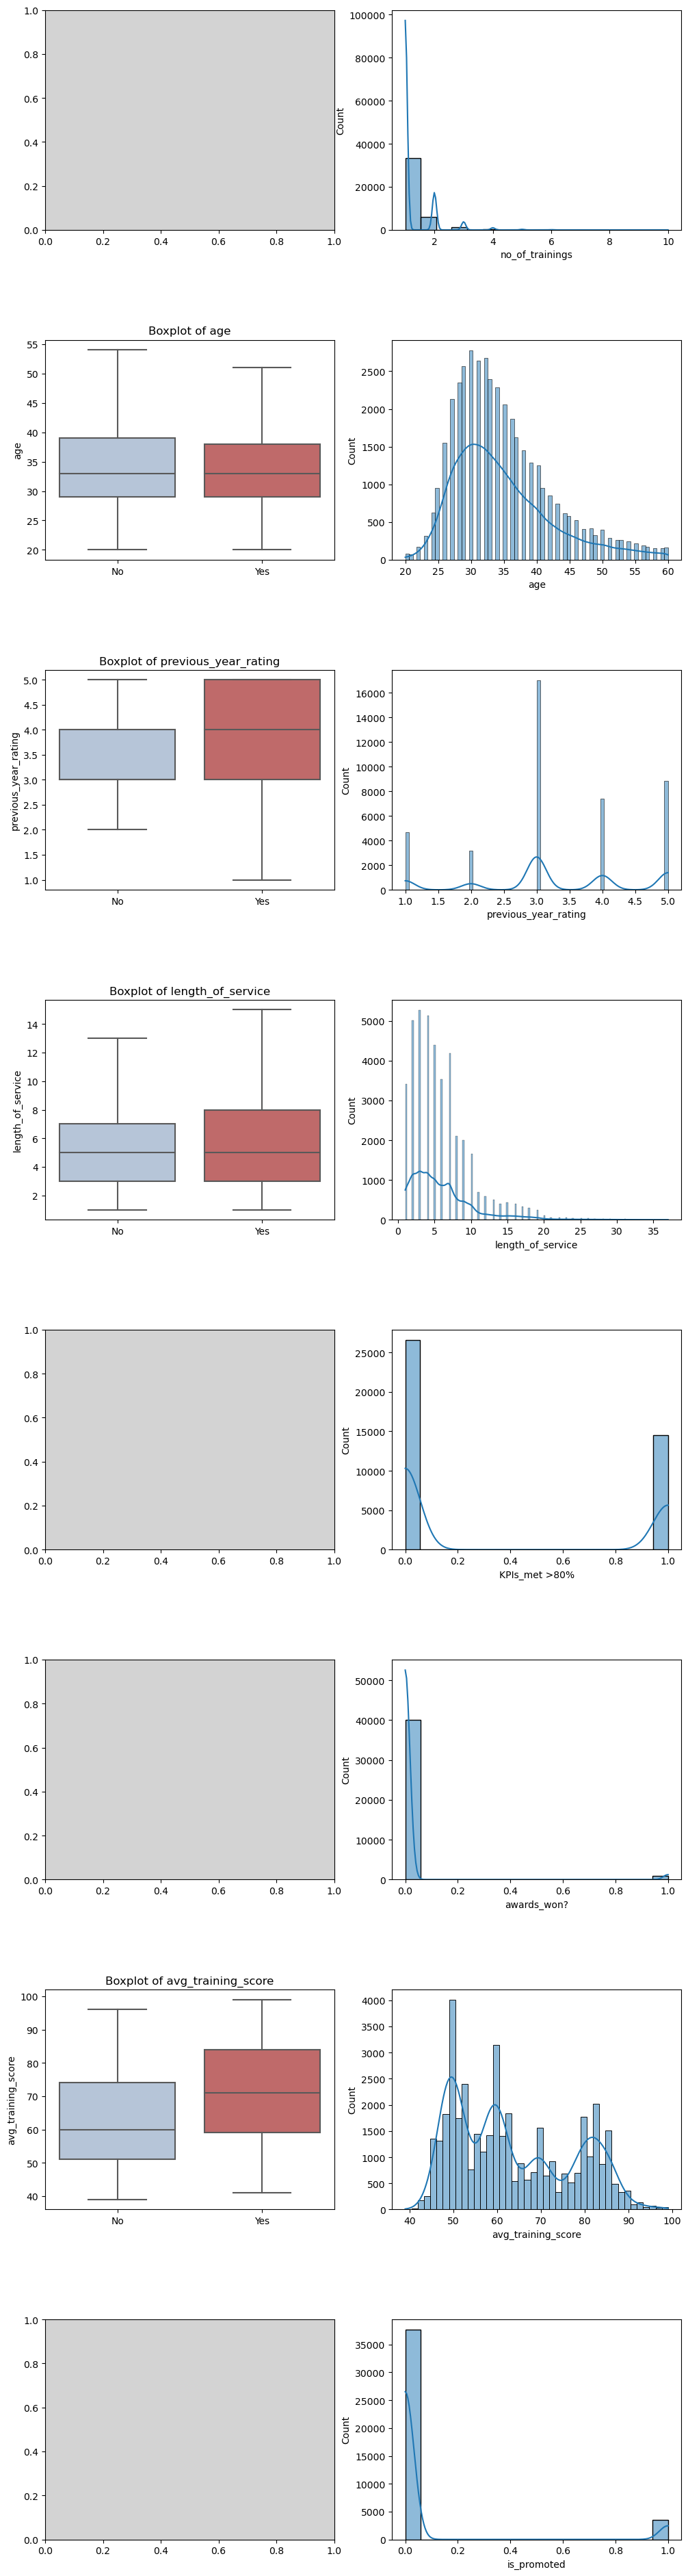

In [41]:
# Visual representation of the numerical variables of the train set attending to their frequency distributions, categories 
# without informative representations have been greyed-out


fig, axes = plt.subplots(nrows=len(numerical.columns), ncols=2, figsize=(12, 6 * len(numerical.columns)))
fig.subplots_adjust(hspace=0.5)
sns.color_palette("Blues", as_cmap=True)

useful_box_plots = ['age', 'previous_year_rating', 'length_of_service', 'avg_training_score']

for col, ax in zip(numerical, axes):
    
    if col in useful_box_plots:

        sns.boxplot(data=train, x=promotions, y=col, ax=ax[0], showfliers = False, palette="blend:lightsteelblue,indianred")
        ax[0].set_title(f"Boxplot of {col}")
        ax[0].set_xlabel("")
    else:
        ax[0].set_facecolor('lightgray')
    
    
    sns.histplot(data=train, x=col, kde=True, ax=ax[1], palette="blend:darkblue,#EDA")


plt.show()

In [43]:
# Select the numerical features to use or models on. Categorical features have been one-hot encoded beforehand

train  = train.select_dtypes(include=['int64','float64','uint8'])
test = test.select_dtypes(include=['int64','float64','uint8'])

In [44]:
# Percentage of promoted people for the dataset

len(train[train['is_promoted']== 1])/len(train['is_promoted']) * 100

8.47808105872622

In [45]:
# Scale the non-dummy variables, validation results (notebook 2) did not showed any improvement using scaling techniques, 
# but given the different scales of the data seems reasonable and harmless to do so

non_dummies = [col for col in train.columns if len(np.unique(train[col])) > 2]

scaler = StandardScaler()

train_scaled = pd.DataFrame(data = scaler.fit_transform(train[non_dummies]), columns = non_dummies)
train = train.drop(columns = non_dummies)
train = train.join(train_scaled)

test_scaled = pd.DataFrame(data = scaler.fit_transform(test[non_dummies]), columns = non_dummies)
test = test.drop(columns = non_dummies)
test.index = test_scaled.index
test = test.join(test_scaled)

In [46]:
# Divide into train, validation, and test

X_train = train.drop('is_promoted',axis = 1)
y_train = train['is_promoted']
X_test = test.drop('is_promoted',axis = 1)
y_test = test['is_promoted']

In [47]:
# Undersample the majority class, method used based on the validation results (notebook 2)

undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [50]:
type(X_train)

pandas.core.frame.DataFrame

In [48]:
# Define the base models to be trained and evaluated

random_state = 4
base_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(random_state=random_state),
    "XGBClassifier": XGBClassifier(random_state=random_state),
    "BaggingClassifier": BaggingClassifier(random_state=random_state),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=random_state),
}

In [73]:
# Function to train a make predictions on the test set, returns a DataFrame with different evaluation metrics along a graphic
# representation of the model's performance and the confusion matrix for the best performing model


def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a dictionary of models using classification metrics.

    Parameters:
        models (dict): A dictionary of models with model names as keys and the corresponding model objects as values.
        X_train (array-like): Training input data.
        y_train (array-like): Training target labels.
        X_test (array-like): Testing input data.
        y_test (array-like): Testing target labels.

    Returns:
        results (pd.DataFrame): DataFrame containing training and evaluation metrics for each model.
        prints (barplot, confusion matrix): data representation of the prediction outcomes.
    """
    
    # Create an empty DataFrame to store results
    results = pd.DataFrame(columns=['training_accuracy', 'Accuracy', 'Recall', 'Precision', 'F1'])

    # Iterate through each model in the dictionary
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Calculate the training accuracy
        training_accuracy = round(model.score(X_train, y_train), 3)
        
        # Predict on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        recall = round(recall_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred), 3)
        f1 = round(f1_score(y_test, y_pred), 3)

        # Add results to the DataFrame
        results.loc[f"{model_name}"] = [training_accuracy, accuracy, recall, precision, f1]
        
    # Sort results based on F1 score in descending order
    results.sort_values(by="F1", ascending=False, inplace=True)
    
    # Create subplots for visualization
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 2))
    
    # Plot F1 scores
    sns.barplot(data=results, x=results['F1'].index, y=results['F1'], ax=axes[0], palette="blend:#98c6ad,#f39c9a")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel("F1 scores")
    
    # Create a confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(matrix, index=np.unique(y_test), columns=np.unique(y_test))
    
    # Plot confusion matrix heatmap
    sns.heatmap(np.eye(2), annot=matrix_df, fmt="d", ax=axes[1], annot_kws={"size": 16}, cmap=sns.color_palette(["#98c6ad", "#f39c9a"]))
    axes[1].set_title(f"Confusion matrix of {results.index[0]}")
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Actual Values")
    
    # Return the results DataFrame
    return results


,training_accuracy,Accuracy,Recall,Precision,F1
XGBClassifier,0.950,0.941,0.352,0.898,0.505
GradientBoostingClassifier,0.941,0.938,0.296,0.970,0.453
Random Forest Classifier,1.000,0.933,0.275,0.831,0.413
Logistic Regression,0.933,0.930,0.256,0.802,0.388


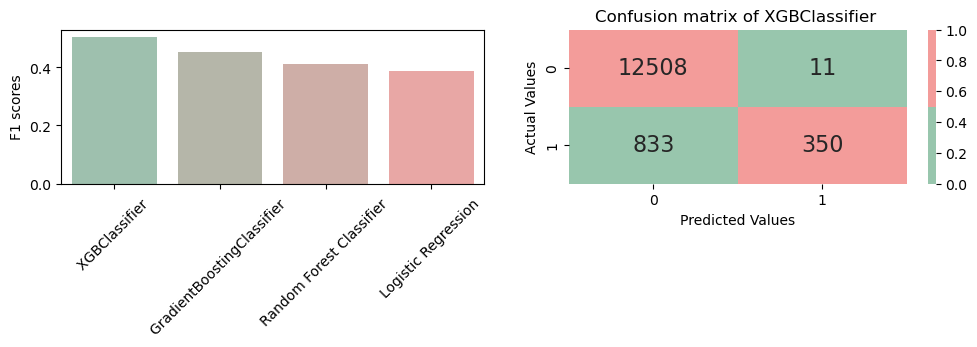

In [74]:
# Result of the scaled model 

results_scaled = train_and_evaluate_models(base_models, X_train, y_train, X_test, y_test)
results_scaled

,training_accuracy,Accuracy,Recall,Precision,F1
XGBClassifier,0.922,0.769,0.855,0.252,0.389
Logistic Regression,0.790,0.770,0.831,0.250,0.384
Random Forest Classifier,1.000,0.748,0.855,0.236,0.369
GradientBoostingClassifier,0.817,0.715,0.928,0.223,0.360


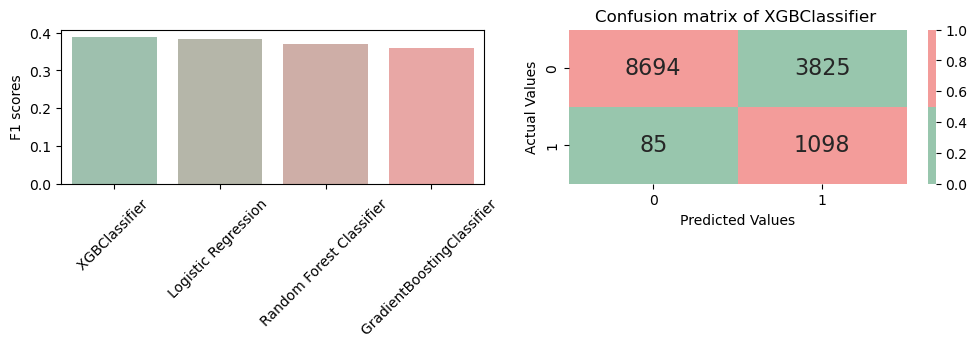

In [75]:
# Results of the scaled model with undersampling done

results_undersampled = train_and_evaluate_models(base_models, X_train_undersampled, y_train_undersampled, X_test, y_test)
results_undersampled